# 시계열 예측 모델
- https://otexts.com/fppkr/arima.html
- ARIMA(자기상관), fbprophet(다중), RNN(다중)
- 시계열예측모델이 단순회귀모델보다 예측률이 좋다.
- 이유는 기존피처에 추가로 sifted한 피처(시간 고려)로 기울기를 계산하여 예측하기 때문
- ARIMA 모델은 시계열을 예측하는 또 하나의 접근 방법입니다.   
지수평활(exponential smoothing)과 ARIMA 모델은 시계열을 예측할 때 가장 널리 사용하는 두 가지 접근 방식이고,   
주어진 문제를 상호 보완적으로 다루도록 하는 접근 방식입니다.
- 지수평활 모델은 데이터의 추세와 계절성(seasonality)에 대한 설명에 기초하고,
- ARIMA 모델은 데이터에 나타나는 자기상관(autocorrelation)을 표현하는데 목적이 있습니다.
- ARIMA 모델을 소개하기에 앞서, 정상성/안정성(stationarity)과 시계열의 차분(differencing)을 구하는 기법을 먼저 다뤄야 합니다.

# 정상성과 차분
- Stationary : white noise, 주기성 행동을 가지고 있지만 추세나 계절성은 없는 시계열
   언제 관찰하더라도 똑같기 때문,  주기가 고정된 길이를 가지고 있지 않기 때문에 시계열을 관측하기 전에는 주기의 고점이나 저점을 확실하게 알 수 없다. 일반적으로는, 정상성을 나타내는 시계열은 장기적으로 볼 때 예측할 수 있는 패턴을 나타내지 않을 것입니다. (어떤 주기적인 행동이 있을 수 있더라도) 시간 그래프는 시계열이 일정한 분산을 갖고 대략적으로 평평하게 될 것을 나타낼 것입니다.
   계절성을 갖는 '주기'가 아님, 정상성의 주기는 불규칙적이므로 장기적으로 예측 안됨.
- 차분 : 
시계열 데이터를 규칙적 시계열 데이터로 활용할 수 있도록 하는 과정을 거친다. 현재 상태의 변수에서 바로 전 상태의 변수를 빼주는 것을 차분이라고 하며, 차분을 거친 결과 변수들이 Whitening 되는 효과

비정상성 시계열을 정상성으로 변경하기 위함, 시계열의 평균 변화를 일정하게함(추세나 계절성 제거됨), 비정상성데이터에서는 acf가 느리게 감소하고, 정상성데이터에서는acf가 빠르게 0으로 

## ACF auto correration function(자기 상관 함수)
정상성을 나타내지 않는 시계열을 찾는 방법

$$ 
\begin{align}
autocovariance function:  C_{h} = \dfrac{1}{N}\sum_{t=1}^{N-h} (Y_{t} - \bar{Y} )(Y_{t+h} - \bar{Y} ) 
\tag{1}
\end{align}
$$

$$ 
\begin{align}
variance function:  C_{0} = \dfrac{1}{N}\sum_{t=1}^{N} (Y_{t} - \bar{Y} )^2 
\tag{2}
\end{align}
$$

$$ 
\begin{align}
autocorrelation coefficient:  R_{h} = \dfrac{Autocovariance}{Variance} = \dfrac{ C_{h} }{C_{0} }
\tag{3}
\end{align}
$$

AR,MA를 지정한뒤 ACF와 PACF의 그래프를 그려보면 ARMA모형의 적합성을 판단할 수 있다.
모델 적합성의 가장 큰 증거는 ACF가 점차 감소하는 모습을 띄는 것이다.

In [1]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")
plt.style.use("ggplot")

In [2]:
birthDF = pd.read_csv('../data/daily-total-female-births.txt', index_col='Date',
                     parse_dates=['Date'])
birthDF

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


In [3]:
airDF = pd.read_csv('../data/international-airline-passengers.txt', index_col='time',
                     parse_dates=['time'])
airDF

,passengers
time,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [4]:
tempDF = pd.read_csv('../data/daily-min-temperatures.csv', index_col='date',
                     parse_dates=['date'])
tempDF

,Temp
date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [5]:
birthN = birthDF.shape[0]//2
birthN

182

In [6]:
# stationary dataset
# 평균과 분산 차이가 적음
print(birthDF.iloc[:birthN].mean())
print(birthDF.iloc[:birthN].var())
print('='*50)
print(birthDF.iloc[birthN:].mean())
print(birthDF.iloc[birthN:].var())

Births    39.763736
dtype: float64
Births    49.485308
dtype: float64
Births    44.185792
dtype: float64
Births    48.976281
dtype: float64


In [7]:
# non-stationary dataset, 평균과 분산차이가 큼
airN = airDF.shape[0]//2
print(airDF.iloc[:airN].mean())
print(airDF.iloc[:airN].var())
print('='*50)
print(airDF.iloc[airN:].mean())
print(airDF.iloc[airN:].var())

passengers    182.902778
dtype: float64
passengers    2275.69464
dtype: float64
passengers    377.694444
dtype: float64
passengers    7471.736307
dtype: float64


In [8]:
# stationary dataset, 평균과 분산차이가 작음
tempN = tempDF.shape[0]//2
print(tempDF.iloc[:tempN].mean())
print(tempDF.iloc[:tempN].var())
print('='*50)
print(tempDF.iloc[tempN:].mean())
print(tempDF.iloc[tempN:].var())

Temp    11.043507
dtype: float64
Temp    18.170782
dtype: float64
Temp    11.312
dtype: float64
Temp    14.961956
dtype: float64


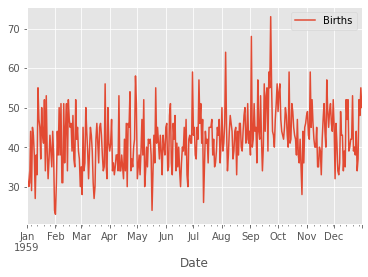

In [9]:
# 구간에 따라서 starionary여부 판별이 어려움
# autoco를 보자
birthDF.plot()
plt.show()

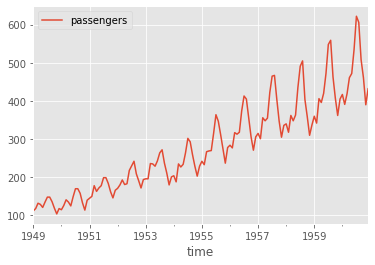

In [10]:
airDF.plot()
plt.show()

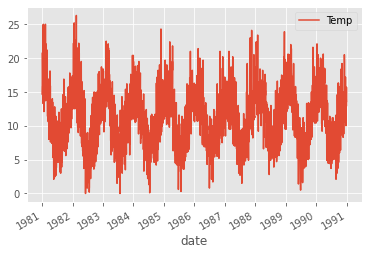

In [11]:
tempDF.plot()
plt.show()

In [12]:
tempDF['days'] = range(0, len(tempDF))
tempDF

,Temp,days
date,,
1981-01-01,20.7,0
1981-01-02,17.9,1
1981-01-03,18.8,2
1981-01-04,14.6,3
1981-01-05,15.8,4
...,...,...
1990-12-27,14.0,3645
1990-12-28,13.6,3646
1990-12-29,13.5,3647


In [13]:
temps = tempDF['Temp'].values
temps

array([20.7, 17.9, 18.8, ..., 13.5, 15.7, 13. ])

In [14]:
temps[1:]

array([17.9, 18.8, 14.6, ..., 13.5, 15.7, 13. ])

In [15]:
temps[:-1]

array([20.7, 17.9, 18.8, ..., 13.6, 13.5, 15.7])

In [16]:
 # lag 1 autocerellation
np.corrcoef(temps[1:], temps[:-1])[0,1]

0.7748702165384455

In [17]:
np.corrcoef(temps[2:], temps[:-2])[0,1] #rag2

0.6311194620684837

In [18]:
# 자기 상관관계가 줄어들경우 stationary
autocrrelation = []
for shift in range(1, 10):
    c = np.corrcoef(temps[:-shift],temps[shift:])[0,1]
    autocrrelation.append(c)
autocrrelation

[0.7748702165384455,
 0.6311194620684837,
 0.5863748620126277,
 0.5788976133377622,
 0.5785715744112058,
 0.5765484145122558,
 0.5759289535831575,
 0.5695569780397493,
 0.5634747178408283]

<function matplotlib.pyplot.show(close=None, block=None)>

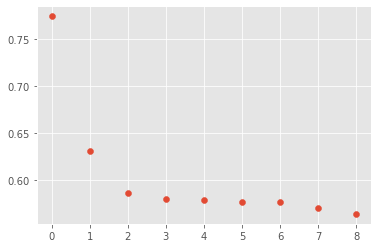

In [19]:
plt.scatter(range(0, len(autocrrelation)), autocrrelation)
plt.show

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, acf

In [21]:
result = acf(tempDF['Temp'])
result
# rag가 적용되기 전에는 1, 

array([1.        , 0.774268  , 0.6302866 , 0.58529312, 0.57774567,
       0.57728013, 0.57510412, 0.57437039, 0.56782622, 0.56120131,
       0.54668689, 0.53793111, 0.54012564, 0.54247126, 0.53688723,
       0.53429917, 0.53043593, 0.52911166, 0.53037444, 0.52280732,
       0.52303677, 0.52224579, 0.51426684, 0.49837745, 0.49302665,
       0.49946731, 0.50428521, 0.50068173, 0.49157081, 0.48146406,
       0.47421245, 0.47568054, 0.46311862, 0.46215585, 0.46630567,
       0.45459092, 0.43378232, 0.4203594 , 0.42707505, 0.42196486,
       0.4079607 ])

<function matplotlib.pyplot.show(close=None, block=None)>

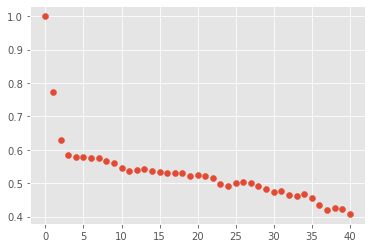

In [22]:
plt.scatter(range(0, len(result)), result)
plt.show

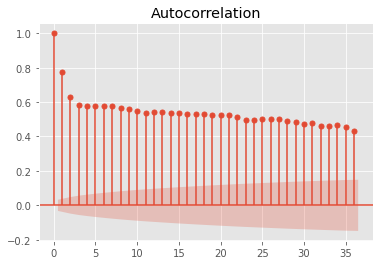

In [23]:
plot_acf(tempDF['Temp'])
plt.show()

##  adfuller 판단지표 : stationary or none-stationary
### 검증 조건 ( p-value : 5% 이내면 reject으로 대체가설 선택됨 )
- 귀무가설(H0): non-stationary.
- 대체가설 (H1): stationary.

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
# stationary (pvalue가 0보다 작음, 0이 5개.. 귀무가설 기각)
result = adfuller(birthDF['Births'])
print(result[0]) # adf 작을 수록 귀무가설을 기각시킬 확률이 높다.
print(result[1]) # p-vlaue 

-4.808291253559764
5.2434129901498554e-05


In [26]:
# none-stationary (pvalue가 0.5보다 큼, 귀무가설 채택)
result1 = adfuller(airDF['passengers'])
print(result1[0]) # adf 작을 수록 귀무가설을 기각시킬 확률이 높다.
print(result1[1]) # p-vlaue 

0.815368879206063
0.9918802434376413


In [27]:
# stationary하다.
result1 = adfuller(tempDF['Temp'])
print(result1[0]) # adf 작을 수록 귀무가설을 기각시킬 확률이 높다.
print(result1[1]) # p-vlaue 

-4.444804924611691
0.00024708263003610866


## ARIMA ( 가장 많이 씀)
- 통계적 기법(띱러닝 아님)으로 단일 피처에만 적용
- original 피처와 shifted된 원피처로 예측한다.(다중선형회귀와 동일)
- ARIMA는 보통 none-stationaly한 시계열 데이터를 예측할 때 사용함.
    - (original)non-stationary를 차분과정을 통해 stationary로 변경하여 예측함
- ARIMA(AR의개수, I의개수, MA의 개수)
    - AR(autoregressive) 자기회귀 : 목표 예상변수에 대해서 과거값으로 예측
    - MA(moving average) : 과거 예측 오차(forecast error)를 이용
    - ARMA(autoregressive and Moving Average) : 2개 모델 결합
- AR filter -> integration filter -> MA filter
    - intergration filter : None Stationary ->차분-> Stationary

\begin{equation}
y_t = 1.6477 y'_{t-1} -0.9094 y'_{t-2} + e_t -1.9101e_{t-1} +0.9999e_{t-2}
\end{equation}
</h3>
를 따르는 ARIMA모델임을 확인할 수 있다.

In [28]:
# 0.12.1의 경우, from statsmodels.tsa.arima_model import ARIMA
# 0.13.1의 경우, from statsmodels.tsa.arima import ARIMA
order = (2, 1, 2)
model = ARIMA(airDF, order)
rfit = model.fit()
rfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D.passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.711
Date:                Wed, 12 Jan 2022   AIC                           1344.043
Time:                        09:59:16   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.passengers     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.passengers    -0.9094      0.033    -27.880      0.000      -0.973      -0.845
ma.L1.D.passengers    -1.9100      0.065    -29.529      0.000      -2.037      -1.783
ma.L2.D.passengers     0.9999      0.068     14.810      0.000       0.868       1.132
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9059           -0.5281j            1.0486           -0.0840
AR.2            0.9059           +0.5281j            1.0486            0.0840
MA.1            0.9551           -0.2964j            1.0001           -0.0479
MA.2            0.9551           +0.2964j            1.0001            0.0479
-----------------------------------------------------------------------------
"""

In [29]:
rfit.aic

1344.043386072241

In [30]:
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [31]:
# aic값이 가장 작은 모델을 선택, 21번
arima_aic_check(airDF, [3,3,3])

,order,AIC
21,p:2 d:1 q:2,1344.043386
20,p:2 d:1 q:1,1361.695809
13,p:1 d:1 q:2,1371.815374
15,p:1 d:2 q:2,1393.908442
23,p:2 d:2 q:2,1394.656208
7,p:0 d:2 q:2,1396.371696
19,p:2 d:1 q:0,1397.975152
4,p:0 d:1 q:2,1398.385532
3,p:0 d:1 q:1,1398.827110
12,p:1 d:1 q:1,1402.145400


In [32]:
rfit.predict(1, 10, typ='levels') # typ= default값이 linear, 예측할때 levels

1949-02-01    114.531095
1949-03-01    121.350895
1949-04-01    137.221342
1949-05-01    129.789527
1949-06-01    119.169414
1949-07-01    136.762407
1949-08-01    149.739078
1949-09-01    147.367310
1949-10-01    134.798629
1949-11-01    121.076958
Freq: MS, dtype: float64

In [33]:
preds = rfit.predict('1960-07-01', '1961-07-01', typ='levels')
preds

1960-07-01    553.884765
1960-08-01    599.046834
1960-09-01    555.150162
1960-10-01    458.019391
1960-11-01    421.197365
1960-12-01    378.526604
1961-01-01    433.104604
1961-02-01    450.859748
1961-03-01    479.773019
1961-04-01    511.929829
1961-05-01    539.283938
1961-06-01    555.774897
1961-07-01    558.734002
Freq: MS, dtype: float64

In [34]:
train = airDF[:'1960-07-01']
test = airDF['1960-07-01':]
test

,passengers
time,
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


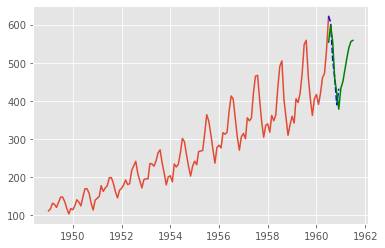

In [35]:
plt.plot(train)
plt.plot(test, 'b--')
plt.plot(preds, 'g')

## ARIMA 연습문제
1. acf 값 구하기
2. adfuller로 stational한지 none-stational한지 체크
3. p, d, q값
4. arima 모델로 예측(2001-11-13, 2001-11-20)
5. 실제값 예측값을 그래프로 그리시오

In [36]:
df = pd.DataFrame([
        ['2001-11-01', 0.998543],
        ['2001-11-02', 1.914526],
        ['2001-11-03', 3.057407],
        ['2001-11-04', 4.044301],
        ['2001-11-05', 4.952441],
        ['2001-11-06', 6.002932],
        ['2001-11-07', 6.930134],
        ['2001-11-08', 8.011137],
        ['2001-11-09', 9.040393],
        ['2001-11-10', 10.097007],
        ['2001-11-11', 11.063742],
        ['2001-11-12', 12.051951],
        ['2001-11-13', 13.062637],
        ['2001-11-14', 14.086016],
        ['2001-11-15', 15.096826],
        ['2001-11-16', 15.944886],
        ['2001-11-17', 17.027107],
        ['2001-11-18', 17.930240],
        ['2001-11-19', 18.984202],
        ['2001-11-20', 19.971603]
    ], columns=['date', 'count'])
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
df = df.set_index('date')
df

,count
date,
2001-11-01,0.998543
2001-11-02,1.914526
2001-11-03,3.057407
2001-11-04,4.044301
2001-11-05,4.952441
2001-11-06,6.002932
2001-11-07,6.930134
2001-11-08,8.011137
2001-11-09,9.040393


In [37]:
# 1. acf  구하기
from statsmodels.graphics.tsaplots import plot_acf, acf

In [38]:
result = acf(df['count'])
result

array([ 1.        ,  0.85051096,  0.70111766,  0.55770427,  0.41727086,
        0.28272744,  0.15409016,  0.03335875, -0.07545946, -0.17166745,
       -0.25369122, -0.32166247, -0.37250429, -0.40465095, -0.41553391,
       -0.40615602, -0.37568118, -0.32135199, -0.24323865, -0.13518252])

<function matplotlib.pyplot.show(close=None, block=None)>

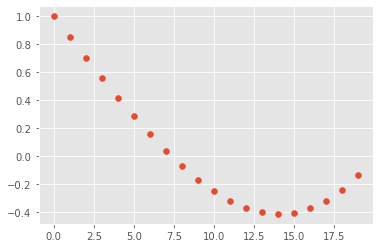

In [39]:
plt.scatter(range(0, len(result)), result)
plt.show

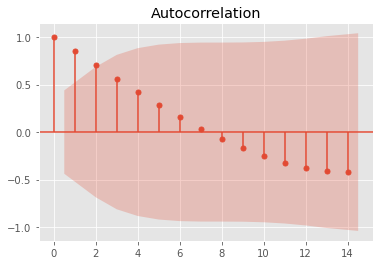

In [40]:
plot_acf(df['count'])
plt.show()

In [41]:
# adfuller로 stational한지 none-stational한지 체크
from statsmodels.tsa.stattools import adfuller
# none-stationary (pvalue가 0.5보다 큼, 귀무가설 채택)
result1 = adfuller(df['count'])
print(result1[0]) # adf 작을 수록 귀무가설을 기각시킬 확률이 높다.
print(result1[1]) # p-vlaue 

-7.573269903544496
2.804546459120648e-11


In [42]:
# 최적의 aic값 구하기 p, d, q값
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [43]:
# aic값이 가장 작은 모델을 선택, 4번 0, 1, 1
arima_aic_check(df, [3,3,3])

,order,AIC
4,p:0 d:1 q:1,-46.510330
10,p:1 d:1 q:0,-46.352253
11,p:1 d:1 q:1,-44.691545
5,p:0 d:1 q:2,-44.595638
17,p:2 d:1 q:0,-44.545073
18,p:2 d:1 q:1,-44.052351
12,p:1 d:1 q:2,-42.796456
3,p:0 d:1 q:0,-41.995440
19,p:2 d:1 q:2,-38.789645
8,p:0 d:2 q:2,-38.039368


In [44]:
order = (0, 1, 1)
model = ARIMA(df, order)
rfit = model.fit()
rfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.count   No. Observations:                   19
Model:                 ARIMA(0, 1, 1)   Log Likelihood                  26.255
Method:                       css-mle   S.D. of innovations              0.060
Date:                Wed, 12 Jan 2022   AIC                            -46.510
Time:                        09:59:21   BIC                            -43.677
Sample:                    11-02-2001   HQIC                           -46.031
                         - 11-20-2001                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.9995      0.006    167.035      0.000       0.988       1.011
ma.L1.D.count    -0.6026      0.213     -2.830      0.005      -1.020      -0.185
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.6596           +0.0000j            1.6596            0.0000
-----------------------------------------------------------------------------
"""

In [45]:
rfit.aic

-46.510329967607895

In [46]:
# arima 모델로 예측(2001-11-13, 2001-11-20)
preds = rfit.predict('2001-11-13', '2001-11-20', typ='levels')
preds

2001-11-13    13.050375
2001-11-14    14.054755
2001-11-15    15.066685
2001-11-16    16.078170
2001-11-17    17.024704
2001-11-18    18.025165
2001-11-19    18.986944
2001-11-20    19.985360
Freq: D, dtype: float64

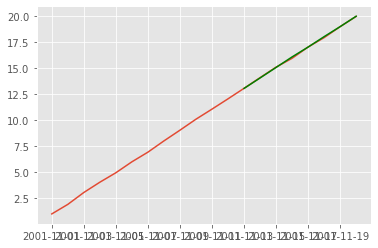

In [47]:
# 실제값 예측값을 그래프로 그리시오
plt.plot(df) 
plt.plot(preds, 'g')
plt.show()

## Quiz : 기상청 날씨 주간 예측

http://www.kma.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109

* 서울~여주지역 12시간단위 주간예보 시계열 예측

1. 데이터 XML 파싱.. 

2. dataframe
- mulit index : 도시, 날짜
- 피처 : 날씨, 최저, 최고

3. EDA
- 1. 도시와 날짜를 인덱스로 설정하시요
- 2. 도시별 최고, 최저기온 평균을 구하시요.
- 3. 최저기온이 가장낮은 도시, 날짜, 최고기온을 구하시요
- 4. 서울지역의 날짜별 최고 최저기온을 바차트로그리시요
- 5. 여주지역 최저기온이 -10 도 이하인데이터를 구하시요
- 6. 여주지역 전체 최고기온 중 최고기온이 0 도 이상이차지하는비율을 구하시요. (예를들어  출력결과:0도이상 15% )
- 7. 일교차 컬럼을 추가하고,최고기온과 최저기온의 차이가 가장높은 도시,날짜,최저,최고,일교차를 구하시요

4. 서울지역 예측
다음 주간 최고기온날씨 예측

In [48]:
from bs4 import BeautifulSoup
import urllib.request as request

In [49]:
#서울 / 경기도 RSS 
url = 'http://www.kma.go.kr/weather/forecast/mid-term-rss3.jsp?stnId=109'

In [50]:
response = request.urlopen(url)
soup = BeautifulSoup(response, "html.parser") # html5lib 시작태그가 빠질경우 코더변경해주자

In [51]:
dt = [{'aa':10, 'bb':40 }, {'aa':20, 'bb':50 }, {'aa':30, 'bb':60 }]
df = pd.DataFrame(dt)
df

,aa,bb
0,10,40
1,20,50
2,30,60


In [52]:
wdata = []
for location in soup.select('location'):
    print(location.city.string)
    print("="*20)
    for data in location.select('data'):
        wdata.append({'도시': location.city.string,
                     '날짜' : data.tmef.string,
                     "날씨" : data.wf.string,
                     "최저" : int(data.tmn.string),
                     "최고" : int(data.tmx.string)
                     })
wdata

서울
인천
수원
파주
이천
평택
백령도
과천
광명
강화
김포
시흥
안산
부천
의정부
고양
양주
동두천
연천
포천
가평
구리
남양주
양평
하남
안양
오산
화성
성남
의왕
군포
안성
용인
광주
여주


[{'도시': '서울', '날짜': '2022-01-15 00:00', '날씨': '구름많음', '최저': -5, '최고': 4},
 {'도시': '서울', '날짜': '2022-01-15 12:00', '날씨': '흐림', '최저': -5, '최고': 4},
 {'도시': '서울', '날짜': '2022-01-16 00:00', '날씨': '구름많고 비/눈', '최저': -2, '최고': 1},
 {'도시': '서울', '날짜': '2022-01-16 12:00', '날씨': '맑음', '최저': -2, '최고': 1},
 {'도시': '서울', '날짜': '2022-01-17 00:00', '날씨': '맑음', '최저': -9, '최고': -1},
 {'도시': '서울', '날짜': '2022-01-17 12:00', '날씨': '맑음', '최저': -9, '최고': -1},
 {'도시': '서울', '날짜': '2022-01-18 00:00', '날씨': '맑음', '최저': -7, '최고': 0},
 {'도시': '서울', '날짜': '2022-01-18 12:00', '날씨': '맑음', '최저': -7, '최고': 0},
 {'도시': '서울', '날짜': '2022-01-19 00:00', '날씨': '맑음', '최저': -7, '최고': -1},
 {'도시': '서울', '날짜': '2022-01-19 12:00', '날씨': '맑음', '최저': -7, '최고': -1},
 {'도시': '서울', '날짜': '2022-01-20 00:00', '날씨': '맑음', '최저': -9, '최고': -1},
 {'도시': '서울', '날짜': '2022-01-21 00:00', '날씨': '맑음', '최저': -7, '최고': 1},
 {'도시': '서울', '날짜': '2022-01-22 00:00', '날씨': '구름많음', '최저': -6, '최고': 1},
 {'도시': '인천', '날짜': '2022-01-15 00:00', '날씨': '구름

In [53]:
wdf = pd.DataFrame(wdata)
wdf

,도시,날짜,날씨,최저,최고
0,서울,2022-01-15 00:00,구름많음,-5,4
1,서울,2022-01-15 12:00,흐림,-5,4
2,서울,2022-01-16 00:00,구름많고 비/눈,-2,1
3,서울,2022-01-16 12:00,맑음,-2,1
4,서울,2022-01-17 00:00,맑음,-9,-1
...,...,...,...,...,...
450,여주,2022-01-19 00:00,맑음,-7,1
451,여주,2022-01-19 12:00,맑음,-7,1
452,여주,2022-01-20 00:00,맑음,-11,0
453,여주,2022-01-21 00:00,맑음,-9,1


In [54]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   도시      455 non-null    object
 1   날짜      455 non-null    object
 2   날씨      455 non-null    object
 3   최저      455 non-null    int64 
 4   최고      455 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 17.9+ KB


In [55]:
wdf['날짜'] = pd.to_datetime(wdf['날짜']+':00')# format='%Y-%m-%d %H:%M:%S'
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455 entries, 0 to 454
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   도시      455 non-null    object        
 1   날짜      455 non-null    datetime64[ns]
 2   날씨      455 non-null    object        
 3   최저      455 non-null    int64         
 4   최고      455 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 17.9+ KB


In [56]:
# 2. EDA :1. 도시와 날짜를 인덱스로 설정하시요
wdf1 = wdf.set_index(['도시','날짜'])
wdf1

날씨  최저  최고
도시 날짜                                   
서울 2022-01-15 00:00:00      구름많음  -5   4
   2022-01-15 12:00:00        흐림  -5   4
   2022-01-16 00:00:00  구름많고 비/눈  -2   1
   2022-01-16 12:00:00        맑음  -2   1
   2022-01-17 00:00:00        맑음  -9  -1
...                          ...  ..  ..
여주 2022-01-19 00:00:00        맑음  -7   1
   2022-01-19 12:00:00        맑음  -7   1
   2022-01-20 00:00:00        맑음 -11   0
   2022-01-21 00:00:00        맑음  -9   1
   2022-01-22 00:00:00      구름많음  -8   1

[455 rows x 3 columns]

In [57]:
wdf1.index

MultiIndex([('서울', '2022-01-15 00:00:00'),
            ('서울', '2022-01-15 12:00:00'),
            ('서울', '2022-01-16 00:00:00'),
            ('서울', '2022-01-16 12:00:00'),
            ('서울', '2022-01-17 00:00:00'),
            ('서울', '2022-01-17 12:00:00'),
            ('서울', '2022-01-18 00:00:00'),
            ('서울', '2022-01-18 12:00:00'),
            ('서울', '2022-01-19 00:00:00'),
            ('서울', '2022-01-19 12:00:00'),
            ...
            ('여주', '2022-01-16 12:00:00'),
            ('여주', '2022-01-17 00:00:00'),
            ('여주', '2022-01-17 12:00:00'),
            ('여주', '2022-01-18 00:00:00'),
            ('여주', '2022-01-18 12:00:00'),
            ('여주', '2022-01-19 00:00:00'),
            ('여주', '2022-01-19 12:00:00'),
            ('여주', '2022-01-20 00:00:00'),
            ('여주', '2022-01-21 00:00:00'),
            ('여주', '2022-01-22 00:00:00')],
           names=['도시', '날짜'], length=455)

In [58]:
# 2. EDA :2. 도시별 최고, 최저기온 평균을 구하시요.
wdf1.groupby('도시').mean().sort_values(by='최저')

,최저,최고
도시,,
연천,-11.769231,-1.846154
가평,-11.307692,0.615385
파주,-10.076923,0.000000
양주,-10.000000,0.000000
포천,-9.846154,0.076923
남양주,-9.076923,-0.076923
의정부,-8.769231,0.000000
동두천,-8.769231,0.769231
광주,-8.538462,0.615385


In [59]:
# 2. EDA : 3. 최저기온이 가장낮은 도시, 날짜, 최고기온을 구하시요
wdf1[wdf1['최저'] == wdf1['최저'].min()] # nsmallest 쓸걸..

날씨  최저  최고
도시 날짜                             
연천 2022-01-17 00:00:00  맑음 -15  -4
   2022-01-17 12:00:00  맑음 -15  -4
   2022-01-18 00:00:00  맑음 -15  -2
   2022-01-18 12:00:00  맑음 -15  -2

In [60]:
wdf1.nsmallest(1, '최저', keep='all')

날씨  최저  최고
도시 날짜                             
연천 2022-01-17 00:00:00  맑음 -15  -4
   2022-01-17 12:00:00  맑음 -15  -4
   2022-01-18 00:00:00  맑음 -15  -2
   2022-01-18 12:00:00  맑음 -15  -2

In [61]:
# 눈이 오는 도시 날짜 날씨를 구하시오
wdf1[wdf1['날씨'].str.contains('눈')][['날씨']]

,,날씨
도시,날짜,
서울,2022-01-16,구름많고 비/눈
인천,2022-01-16,구름많고 비/눈
수원,2022-01-16,구름많고 비/눈
파주,2022-01-16,구름많고 비/눈
이천,2022-01-16,구름많고 비/눈
평택,2022-01-16,구름많고 비/눈
백령도,2022-01-16,구름많고 비/눈
과천,2022-01-16,구름많고 비/눈
광명,2022-01-16,구름많고 비/눈


<AxesSubplot:xlabel='날짜'>

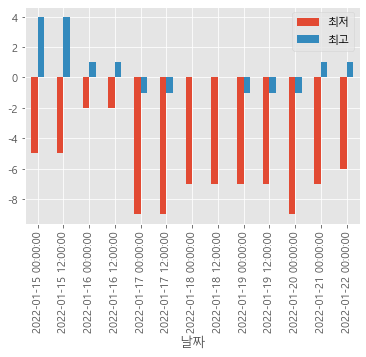

In [62]:
# 2. EDA : 4.서울지역의 날짜별 최고 최저기온을 바차트로그리시요
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use("ggplot")
# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm
#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 11.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

wdf1.loc['서울'].plot(kind='bar')

In [63]:
# 2. EDA : 5.여주지역 최저기온이 -10 도 이하인 데이터를 구하시요
wdf1.loc['여주'][['최저']][wdf1.loc['여주']['최저'] <= -10]

,최저
날짜,
2022-01-17 00:00:00,-10
2022-01-17 12:00:00,-10
2022-01-18 00:00:00,-10
2022-01-18 12:00:00,-10
2022-01-20 00:00:00,-11


In [64]:
wdf1.loc['여주'].query('최저<=-10')

,날씨,최저,최고
날짜,,,
2022-01-17 00:00:00,맑음,-10,-1
2022-01-17 12:00:00,맑음,-10,-1
2022-01-18 00:00:00,맑음,-10,-1
2022-01-18 12:00:00,맑음,-10,-1
2022-01-20 00:00:00,맑음,-11,0


In [65]:
# 2. EDA : 6.여주지역 전체 최고기온 중 최고기온이 0 도 
#           이상이차지하는비율을 구하시요. (예를들어 출력결과:0도이상 15% )
wdf1_y = wdf1.loc['여주'][['최고']]
result = len(wdf1_y[wdf1_y.values >= 0]) / len(wdf1_y) * 100
print(f'0도 이상 비율 : {result:.2f}')

0도 이상 비율 : 69.23


In [66]:
# 2. EDA : 7. 일교차 컬럼을 추가하고,
# 최고기온과 최저기온의 차이가 가장높은 도시,날짜,최저,최고,일교차를 구하시요
wdf1['일교차'] =  wdf1['최고']-wdf1['최저']
wdf1

날씨  최저  최고  일교차
도시 날짜                                        
서울 2022-01-15 00:00:00      구름많음  -5   4    9
   2022-01-15 12:00:00        흐림  -5   4    9
   2022-01-16 00:00:00  구름많고 비/눈  -2   1    3
   2022-01-16 12:00:00        맑음  -2   1    3
   2022-01-17 00:00:00        맑음  -9  -1    8
...                          ...  ..  ..  ...
여주 2022-01-19 00:00:00        맑음  -7   1    8
   2022-01-19 12:00:00        맑음  -7   1    8
   2022-01-20 00:00:00        맑음 -11   0   11
   2022-01-21 00:00:00        맑음  -9   1   10
   2022-01-22 00:00:00      구름많음  -8   1    9

[455 rows x 4 columns]

In [67]:
wdf1[wdf1['일교차'] == wdf1['일교차'].max()] # nlargest 쓰자 제발..

날씨  최저  최고  일교차
도시 날짜                                    
포천 2022-01-18 00:00:00    맑음 -13   1   14
   2022-01-18 12:00:00    맑음 -13   1   14
가평 2022-01-18 00:00:00    맑음 -14   0   14
   2022-01-18 12:00:00    맑음 -14   0   14
   2022-01-20 00:00:00    맑음 -13   1   14
   2022-01-22 00:00:00  구름많음 -12   2   14

In [68]:
wdf1.nlargest(1, '일교차', keep='all')

날씨  최저  최고  일교차
도시 날짜                                    
포천 2022-01-18 00:00:00    맑음 -13   1   14
   2022-01-18 12:00:00    맑음 -13   1   14
가평 2022-01-18 00:00:00    맑음 -14   0   14
   2022-01-18 12:00:00    맑음 -14   0   14
   2022-01-20 00:00:00    맑음 -13   1   14
   2022-01-22 00:00:00  구름많음 -12   2   14

In [69]:
# 서울지역 예측 다음 주간 최고기온날씨 예측
data = wdf1[['최고']]
data

최고
도시 날짜                     
서울 2022-01-15 00:00:00   4
   2022-01-15 12:00:00   4
   2022-01-16 00:00:00   1
   2022-01-16 12:00:00   1
   2022-01-17 00:00:00  -1
...                     ..
여주 2022-01-19 00:00:00   1
   2022-01-19 12:00:00   1
   2022-01-20 00:00:00   0
   2022-01-21 00:00:00   1
   2022-01-22 00:00:00   1

[455 rows x 1 columns]

In [70]:
# 평균과 분산차이가 크다, none-stationary로 추정됨
dataN = data.shape[0]//2
print(data.iloc[:dataN].mean())
print(data.iloc[:dataN].var())
print('='*50)
print(data.iloc[dataN:].mean())
print(data.iloc[dataN:].var())

최고    0.581498
dtype: float64
최고    3.14709
dtype: float64
최고    0.447368
dtype: float64
최고    3.03246
dtype: float64


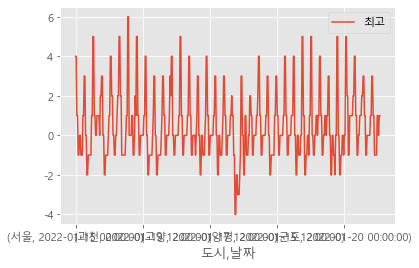

In [71]:
data.plot()
plt.show()

In [72]:
# ACF 확인
from statsmodels.graphics.tsaplots import plot_acf, acf
result = acf(data)
result

array([ 1.        ,  0.63779084,  0.26987414, -0.01746446, -0.29159421,
       -0.25111675, -0.21922098, -0.22477068, -0.26599244, -0.32827091,
       -0.08232238,  0.17575465,  0.48238645,  0.78045695,  0.4770965 ,
        0.16303443, -0.10326785, -0.3638626 , -0.31912488, -0.28294846,
       -0.27494278, -0.29298789, -0.33743033, -0.09576245,  0.1608877 ,
        0.4675195 ,  0.7534615 ,  0.4619034 ,  0.15250927, -0.10735165,
       -0.35793783, -0.30924562, -0.27162193, -0.25717489, -0.27805338,
       -0.32604264, -0.09648288,  0.15696697,  0.44506968,  0.71819013,
        0.44088047])

<function matplotlib.pyplot.show(close=None, block=None)>

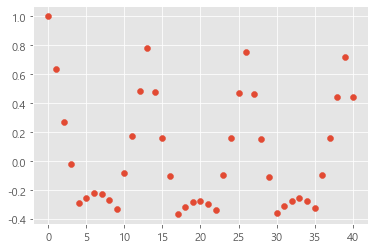

In [73]:
plt.scatter(range(0, len(result)), result)
plt.show

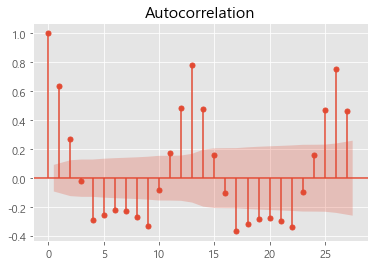

In [74]:
plot_acf(data)
plt.show()

In [75]:
# adfuller 로 검증해보자 , 0.05보다 작아서 귀무가설 기각, none stationary맞는듯
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
print(result[0]) # adf 작을 수록 귀무가설을 기각시킬 확률이 높다.
print(result[1]) # p-vlaue

-5.078402614615371
1.5490723196668304e-05


In [76]:
# aic값을 찾아보자
def arima_aic_check(data, order,sort = 'AIC'):
    order_list = []
    aic_list = []
    bic_lsit = []
    for p in range(order[0]):
        for d in range(order[1]):
            for q in range(order[2]):
                model = ARIMA(data, order=(p,d,q))
                try:
                    model_fit = model.fit()
                    c_order = f'p:{p} d:{d} q:{q}'
                    aic = model_fit.aic
                    bic = model_fit.bic
                    order_list.append(c_order)
                    aic_list.append(aic)
                    bic_list.append(bic)
                except:
                    pass
    result_df = pd.DataFrame(list(zip(order_list, aic_list)),columns=['order','AIC'])
    result_df.sort_values(sort, inplace=True)
    return result_df

In [77]:
# aic값이 가장 작은 모델을 선택,  19번 2,0,2이 가장 좋음
arima_aic_check(data,[3,3,3])

,order,AIC
19,p:2 d:0 q:2,1517.266345
18,p:2 d:0 q:1,1520.767209
22,p:2 d:1 q:2,1531.050171
17,p:2 d:0 q:0,1546.694293
21,p:2 d:1 q:1,1550.779314
10,p:1 d:0 q:1,1551.297299
11,p:1 d:0 q:2,1552.300939
14,p:1 d:1 q:2,1555.242692
2,p:0 d:0 q:2,1563.389843
1,p:0 d:0 q:1,1568.220021


In [78]:
order = (2, 0, 2)
model = ARIMA(data, order)
rfit = model.fit()
rfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                     최고   No. Observations:                  455
Model:                     ARMA(2, 2)   Log Likelihood                -752.633
Method:                       css-mle   S.D. of innovations              1.263
Date:                Wed, 12 Jan 2022   AIC                           1517.266
Time:                        09:59:26   BIC                           1541.988
Sample:                             0   HQIC                          1527.006
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5169      0.105      4.938      0.000       0.312       0.722
ar.L1.최고       1.0783      0.045     23.774      0.000       0.989       1.167
ar.L2.최고      -0.7277      0.074     -9.779      0.000      -0.874      -0.582
ma.L1.최고      -0.5331      0.094     -5.701      0.000      -0.716      -0.350
ma.L2.최고       0.6813      0.115      5.916      0.000       0.456       0.907
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.7409           -0.9084j            1.1723           -0.1411
AR.2            0.7409           +0.9084j            1.1723            0.1411
MA.1            0.3913           -1.1466j            1.2115           -0.1977
MA.2            0.3913           +1.1466j            1.2115            0.1977
-----------------------------------------------------------------------------
"""

In [79]:
# 미래날짜를 예측하면 key error 발생\
# https://stackoverflow.com/questions/62982119/time-series-python-key-error-start-argument-could-not-be-matched
rfit.predict( ('서울','2022-01-19 00:00:00'), ('서울','2022-01-20 00:00:00'), typ='levels')

도시  날짜                 
서울  2022-01-19 00:00:00    0.780276
    2022-01-19 12:00:00   -0.308447
    2022-01-20 00:00:00   -0.846509
dtype: float64

In [ ]:
# ARIMA에 멀티인덱스를 넣어서 훈련시키면 안됨, 예측이 달라짐.

In [80]:
#  보다시피 12시 시간 데이터가 없음, 결측치 처리 필요
wdf1.loc['서울'].index
#seoul = wdf1.loc['서울']
# seoul.index = pd.to_datetime(seoul.index)
# seoul.index

DatetimeIndex(['2022-01-15 00:00:00', '2022-01-15 12:00:00',
               '2022-01-16 00:00:00', '2022-01-16 12:00:00',
               '2022-01-17 00:00:00', '2022-01-17 12:00:00',
               '2022-01-18 00:00:00', '2022-01-18 12:00:00',
               '2022-01-19 00:00:00', '2022-01-19 12:00:00',
               '2022-01-20 00:00:00', '2022-01-21 00:00:00',
               '2022-01-22 00:00:00'],
              dtype='datetime64[ns]', name='날짜', freq=None)